In [1]:
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import Select
from selenium import webdriver
import matplotlib.pyplot as plt
import time
import pandas as pd
import openpyxl
import os
import seaborn as sns
import plotly.express as px
import re

# web: https://portal.3gpp.org/Specifications.aspx
# date: 2023/3/8

In [8]:
df = pd.read_excel("reference/Work_plan_3gpp_230110.xlsm")

# 舊版specification資料
# ws = openpyxl.load_workbook('reference/2023-03-07_1805_SpecificationList_2e6c4e.xlsx')['Specifications']
# SpecificationList_df = pd.read_excel("reference/2023-03-07_1805_SpecificationList_2e6c4e.xlsx")

SpecificationList_df = pd.read_excel("reference/2023-05-19_0651_SpecificationList_3e62b3.xlsx")
ws = openpyxl.load_workbook('reference/2023-05-19_0651_SpecificationList_3e62b3.xlsx')['Specifications']


try:
    output = pd.read_excel("spec_result_all_cleaned.xlsx")

except:
    output = pd.DataFrame()
    
spec_result_all = pd.read_excel("spec_result_all.xlsx")
output_ori = pd.read_excel("spec_result_all.xlsx")

# 1. 篩選提交至Work plan之specification資料並補上SPR企業

### 第一次篩選

In [44]:
def set_info_dict(spec, wpid):
    global driver
    df_index = list(SpecificationList_df['Spec No']).index(spec)
    driver.get(ws[f'A{df_index+2}'].hyperlink.target)
    time.sleep(0.5)
    responsibility_btn = driver.find_elements(By.XPATH, '//*[@class="rtsTxt"]')[2]     
    responsibility_btn.click()
    try:
        company = driver.find_element(By.XPATH, "//*[@class='companyStyleColumn']").text
    except:
        company = ""
        
    spec_info = SpecificationList_df.loc[df_index]

    return pd.DataFrame({
#         'Unique_ID': wpid,
        'Spec No': spec,
        'Type': spec_info[1],
        'Title': spec_info[2],
        'Status': spec_info[3],
        'Primary Resp Grp': spec_info[4],
        'Primary rapporteur name': spec_info[5],
        'Primary rapporteur company':company,
        'Initial planned Release': spec_info[6],
        'Publication': spec_info[7],
        'Common IMS': spec_info[8],
        'Technology': spec_info[9],
    }, index=[0])

In [45]:
driver = webdriver.Chrome(ChromeDriverManager().install())

for index, row in df.iterrows():
    
    # 讀取每一個work plan id
    wp_id = row['Unique_ID']
    
    # 如果該work plan有多個spec，需要拆分後各別爬取
    if type(row['Impacted TSs and TRs']) == str:

        for spec in row['Impacted TSs and TRs'].replace(',',';').replace('; ',';').replace(' ',';').split(';'):
            
            if len(spec) > 3 and spec not in list(output.loc[output.Unique_ID == wp_id]['Spec No']):
                    
                    if spec in list(SpecificationList_df['Spec No']):
                        output = pd.concat([output, set_info_dict(spec, wp_id)], axis=0, ignore_index=True)
                    elif spec+'0' in list(SpecificationList_df['Spec No']):
                        output = pd.concat([output, set_info_dict(spec+'0', wp_id)], axis=0, ignore_index=True)
                    else:
                        print(wp_id, spec)
  
    # 如果該work plan只有1個spec，可直接爬取
    elif str(row['Impacted TSs and TRs']) != 'nan':
        
        spec = str(row['Impacted TSs and TRs'])
            
        if spec not in list(output.loc[output.Unique_ID == wp_id]['Spec No']):

            if spec in list(SpecificationList_df['Spec No']):
                output = pd.concat([output, set_info_dict(spec, wp_id)], axis=0, ignore_index=True)
            elif spec+'0' in list(SpecificationList_df['Spec No']):
                output = pd.concat([output, set_info_dict(spec+'0', wp_id)], axis=0, ignore_index=True)
            else:
                print(wp_id, spec)

len(output)

13652

In [19]:
output.drop_duplicates()
len(output)

13652

In [50]:
output.to_excel('spec_result.xlsx', encoding='utf_8_sig', index=False)

### 第二次篩選

In [8]:
spec_result_all.drop_duplicates(inplace=True)
spec_result_all.head(1)

,Spec No,Type,Title,Status,Primary Resp Grp,Primary rapporteur name,Primary rapporteur company,Initial planned Release,Publication,Common IMS,Technology
0,22.261,Technical Specification (TS),Service requirements for the 5G system,Under change control,S1,Alice Li,VODAFONE Group Plc,Rel-15,For publication,False,5G


In [9]:
spec_info = {}

def set_all_spec_info_dict(spec):
    global driver
    df_index = list(SpecificationList_df['Spec No']).index(spec)
    driver.get(ws[f'A{df_index+2}'].hyperlink.target)
    time.sleep(0.5)
    responsibility_btn = driver.find_elements(By.XPATH, '//*[@class="rtsTxt"]')[2]     
    responsibility_btn.click()
    try:
        company = driver.find_element(By.XPATH, "//*[@class='companyStyleColumn']").text
    except:
        company = ""
        
    spec_info = SpecificationList_df.loc[df_index]

    return pd.DataFrame({
#         'Unique_ID': wpid,
        'Spec No': spec,
        'Type': spec_info[1],
        'Title': spec_info[2],
        'Status': spec_info[3],
        'Primary Resp Grp': spec_info[4],
        'Primary rapporteur name': spec_info[5],
        'Primary rapporteur company':company,
        'Initial planned Release': spec_info[6],
        'Publication': spec_info[7],
        'Common IMS': spec_info[8],
        'Technology': spec_info[9],
    }, index=[0])

In [2]:
driver = webdriver.Chrome(ChromeDriverManager().install())

for i in range(1, ws.max_row - 1):
    cur_spec = ws.cell(1 + i, 1)
    if cur_spec.value not in list(spec_result_all['Spec No']):
#         spec_info[cur_spec.value] = set_all_spec_info_dict(cur_spec.value)
        spec_result_all = pd.concat([spec_result_all, set_all_spec_info_dict(cur_spec.value)], axis=0, ignore_index=True)

In [3]:
len(spec_result_all)
display(spec_result_all)

In [4]:
# df = pd.DataFrame.from_dict(spec_info, orient='index')
spec_result_all.to_excel('spec_result_all.xlsx', encoding='utf_8_sig', index=False)

# 2. 整理表格資料

## 2-1 設定Tech Across Type: 技術跨越型態

In [17]:
output = pd.read_excel("spec_result_all.xlsx")

In [18]:
set_type = {
    'type 1': '2G,3G',
    'type 2': '2G,3G,LTE',
    'type 3': '2G,3G,5G,LTE',
    'type 4': '3G,LTE',
    'type 5': '3G,5G,LTE',
    'type 6': '5G,LTE',    
}

tech_type = []

for index, row in output.iterrows():

    try:
        tech_type_id = list(set_type.values()).index(row['Technology'])
        tech_type.append(list(set_type.keys())[tech_type_id])
        
    except:
        tech_type.append('None')
        if ',' in str(row['Technology']):
            print(row['Technology'])
        
print(len(output))
print(len(tech_type))

4137
4137


In [20]:
output.insert(11, 'Across Tech', tech_type)
output.head(2)

,Spec No,Type,Title,Status,Primary Resp Grp,Primary rapporteur name,Primary rapporteur company,Initial planned Release,Publication,Common IMS,Technology,Across Tech
0,22.261,Technical Specification (TS),Service requirements for the 5G system,Under change control,S1,Alice Li,VODAFONE Group Plc,Rel-15,For publication,False,5G,None
1,22.153,Technical Specification (TS),Multimedia priority service,Under change control,S1,James Garrahan,Applied Communication Sciences,Rel-8,For publication,True,"2G,3G,5G,LTE",type 3


### 技術跨越型態佔比分析

In [21]:
across_tech_c = output['Across Tech'].value_counts().reset_index()
across_tech_c.columns = ['Across Tech', 'Count']
across_tech_c.sort_values('Across Tech', ascending=True, inplace=True)
across_tech_c.insert(1, 'meaning', [""]+list(set_type.values()))
across_tech_c.insert(3, 'ratio', [f"{round(i* 100 / across_tech_c['Count'].sum(), 2)}%" for i in across_tech_c['Count']])
display(across_tech_c)

across_tech_c.to_excel('spec_across_tech.xlsx', encoding='utf_8_sig', index=False)

,Across Tech,meaning,Count,ratio
0,None,,2378,57.48%
3,type 1,"2G,3G",255,6.16%
1,type 2,"2G,3G,LTE",563,13.61%
5,type 3,"2G,3G,5G,LTE",133,3.21%
2,type 4,"3G,LTE",488,11.8%
6,type 5,"3G,5G,LTE",110,2.66%
4,type 6,"5G,LTE",210,5.08%


C:\Users\Penny\anaconda3\lib\site-packages\pandas\util\_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)


## 2-2 整理Primary Resp Grp(C, S, R)，新增Technical Specification Groups欄位

In [23]:
tsg = []
for i in output['Primary Resp Grp']:
    tsg.append(re.sub('[0-9]','',i))

output.insert(5, 'Technical Specification Groups', tsg)

output.head(3)

,Spec No,Type,Title,Status,Primary Resp Grp,Technical Specification Groups,Primary rapporteur name,Primary rapporteur company,Initial planned Release,Publication,Common IMS,Technology,Across Tech
0,22.261,Technical Specification (TS),Service requirements for the 5G system,Under change control,S1,S,Alice Li,VODAFONE Group Plc,Rel-15,For publication,False,5G,None
1,22.153,Technical Specification (TS),Multimedia priority service,Under change control,S1,S,James Garrahan,Applied Communication Sciences,Rel-8,For publication,True,"2G,3G,5G,LTE",type 3
2,22.916,Technical Report (TR),Study on Network of Service Robots with Ambien...,Draft,S1,S,Ki-Dong Lee,LG Electronics Inc.,Rel-19,For publication,False,5G,None


## 2-3 統一Primary rapporteur company中企業名稱

In [24]:
output['Primary rapporteur company'] = output['Primary rapporteur company'].str.lower()
big_companys = ['nokia', 'huawei', 'qualcomm', 'ericsson', 'samsung', 'motorola', 'china mobile', 'at&t','china telecom', 'cisco', 'intel', 'interdigital', 'lg electronics', 'nec', 'oppo', 'orange', 'docomo', 'alcatel-lucent', 'airbus','vodafone', 'vivo','zte', 'apple','lenovo','trueposition', 'fujitsu', 't-mobile', 'trueposition', 'futurewei', 'telefonica', 'xiaomi', 'philips']

for company in big_companys:
    output.replace({'Primary rapporteur company': fr'.*{company}.*$'}, {'Primary rapporteur company': f'{company}'}, regex=True,inplace=True)

In [5]:
for i in output['Primary rapporteur company'].value_counts().index.sort_values():
    print(i)

## 2-4 新增Country: SPR企業所屬國家

In [26]:
cmpy_data = pd.read_excel("reference/spec company country.xlsx")
cmpy_data.head(3)

,公司,國家,country
0,advantest corporation,日本,Japan
1,airbus,法國,France
2,alcatel-lucent,法國,France


In [6]:
cmpy_country = []

for index, row in output.iterrows():

    try:
#         print(row['Primary rapporteur company'])
        cmpy_id = list(cmpy_data['公司']).index(row['Primary rapporteur company'])
#         print(cmpy_data['country'].iloc[cmpy_id])
        cmpy_country.append(cmpy_data['country'].iloc[cmpy_id])
        
    except:
        cmpy_country.append('')
        print(row['Primary rapporteur company'])
        
print(len(output))
print(len(cmpy_country))

In [29]:
output.insert(8, 'Country', cmpy_country)
output.head(10)

,Spec No,Type,Title,Status,Primary Resp Grp,Technical Specification Groups,Primary rapporteur name,Primary rapporteur company,Country,Initial planned Release,Publication,Common IMS,Technology,Across Tech
0,22.261,Technical Specification (TS),Service requirements for the 5G system,Under change control,S1,S,Alice Li,vodafone,U.K.,Rel-15,For publication,False,5G,None
1,22.153,Technical Specification (TS),Multimedia priority service,Under change control,S1,S,James Garrahan,applied communication sciences,Indonesia,Rel-8,For publication,True,"2G,3G,5G,LTE",type 3
2,22.916,Technical Report (TR),Study on Network of Service Robots with Ambien...,Draft,S1,S,Ki-Dong Lee,lg electronics,South Korea,Rel-19,For publication,False,5G,None
3,22.882,Technical Report (TR),Study on Energy Efficiency as service criteria,Draft,S1,S,Xiaonan Shi,china mobile,China,Rel-19,Internal,False,5G,None
4,22.841,Technical Report (TR),"Study on Upper layer traffic steering, switchi...",Draft,S1,S,Francesco Pica,qualcomm,U.S.,Rel-19,Internal,False,5G,None
5,22.877,Technical Report (TR),Study on roaming value added services,Under change control,S1,S,Peter Bleckert,ericsson,Sweden,Rel-19,Internal,False,5G,None
6,22.875,Technical Report (TR),Study on AI/ML Model Transfer Phase 2,Withdrawn before change control,S1,S,Yang Xu,oppo,China,Rel-19,Internal,False,5G,None
7,22.876,Technical Report (TR),Study on AI/ML Model Transfer Phase2,Draft,S1,S,Yang Xu,oppo,China,Rel-19,Internal,False,5G,None
8,22.837,Technical Report (TR),Study on Integrated Sensing and Communication,Draft,S1,S,Vasil Aleksiev,deutsche telekom ag,Germany,Rel-19,Internal,False,5G,None
9,22.856,Technical Report (TR),Study on Localized Mobile Metaverse Services,Draft,S1,S,Erik Guttman,samsung,South Korea,Rel-19,Internal,False,5G,None


### SPR企業所屬國家之Top 10

In [30]:
output.Country.value_counts()[:10]

China          950
Finland        622
Sweden         587
U.S.           503
France         205
none           203
U.K.           161
South Korea    157
Germany        156
Japan          154
Name: Country, dtype: int64

In [7]:
output.to_excel('spec_result_all_cleaned2.xlsx', encoding='utf_8_sig', index=False)

# 3. 趨勢圖分析

In [72]:
output = output.assign(Technology=output.Technology.str.split(",")).explode("Technology")
display(output.head(3))

,Spec No,Type,Title,Status,Primary Resp Grp,Technical Specification Groups,Primary rapporteur name,Primary rapporteur company,Country,Initial planned Release,Publication,Common IMS,Technology,Across Tech
0,22.261,Technical Specification (TS),Service requirements for the 5G system,Under change control,S1,S,Alice Li,vodafone,U.K.,Rel-15,For publication,False,5G,None
1,22.153,Technical Specification (TS),Multimedia priority service,Under change control,S1,S,James Garrahan,applied communication sciences,Indonesia,Rel-8,For publication,True,2G,type 3
1,22.153,Technical Specification (TS),Multimedia priority service,Under change control,S1,S,James Garrahan,applied communication sciences,Indonesia,Rel-8,For publication,True,3G,type 3


## 3-1 華為在不同技術時代下之資源策略佈局

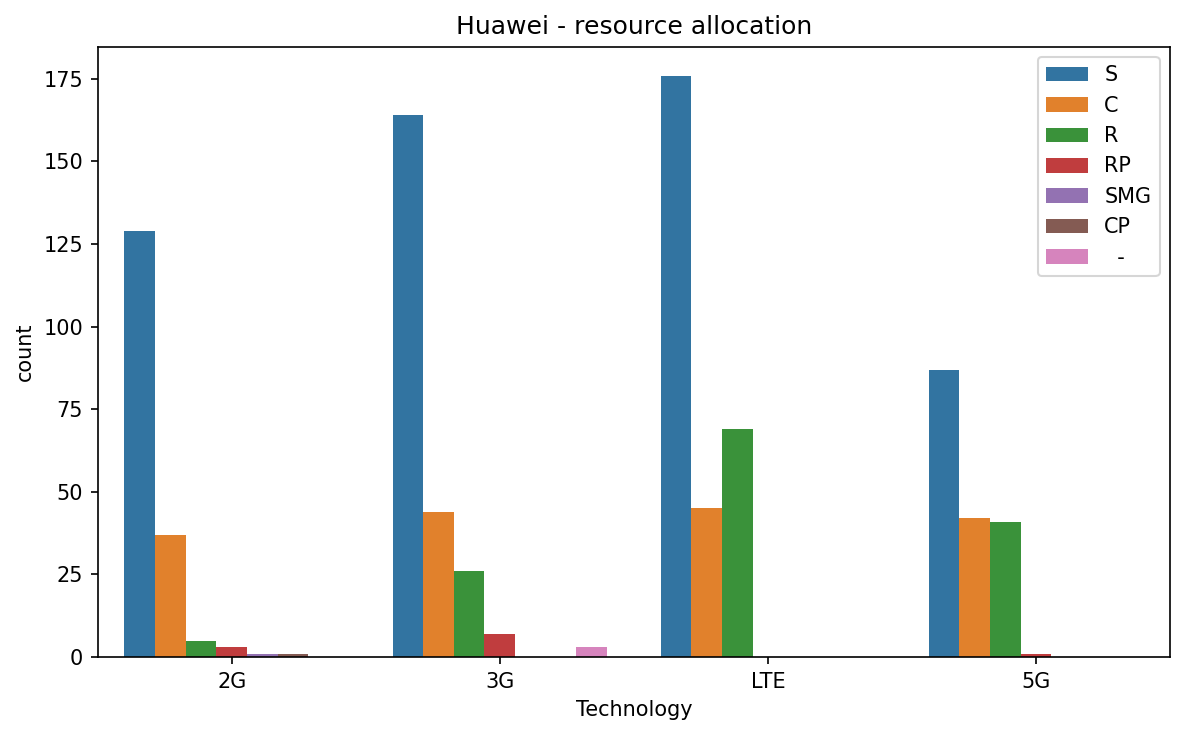

In [4]:
plt.figure(figsize=(8,5),dpi=150)

sns.countplot(x='Technology', hue='Technical Specification Groups', 
              data=output.loc[output['Primary rapporteur company'] == 'huawei'],
              order=['2G', '3G', 'LTE', '5G'] )

plt.title('Huawei - resource allocation')
plt.legend(loc='upper right')
plt.tight_layout()
# plt.savefig(f'result/Huawei - resource allocation - all.png')

## 3-2 Top 10 國家參與程度 (retired)

In [5]:
# pd.DataFrame(output.Country.value_counts()[:10])
country_list = [str(i) for i in output.Country.value_counts()[:10].index]
country_list.append('Others')
count_list = list(output.Country.value_counts())[:10]
count_list.append(output.Country.value_counts()[10:].sum())

top_10_contries = pd.DataFrame.from_dict({'country':country_list,'count':count_list})
top_10_contries.info()
top_10_contries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   country  11 non-null     object
 1   count    11 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 304.0+ bytes


,country,count
0,China,1528
1,Finland,1110
2,Sweden,1092
3,U.S.,737
4,France,375
5,Germany,274
6,U.K.,260
7,South Korea,243
8,none,241
9,Japan,240


In [5]:
# fig = px.pie(labels=country_list,
#              values=count_list,
#              title="國家參與程度",
#              names=country_list,
#              hole=0.6
#             )

# fig.update_traces(textposition='outside', 
#                   textinfo="label+value+percent", 
#                   textfont_size=10)

# fig.show()

## 3-3 不同技術時代與TSG－企業/國家投入程度

In [6]:
output_2G = output.loc[output.Technology == '2G']
output_3G = output.loc[output.Technology == '3G']
output_LTE = output.loc[output.Technology == 'LTE']
output_5G = output.loc[output.Technology == '5G']

print(len(output_2G))
print(len(output_3G))
print(len(output_LTE))
print(len(output_5G))
output_3G.head(1)

1640
2051
1931
1126


,Spec No,Type,Title,Status,Primary Resp Grp,Technical Specification Groups,Primary rapporteur name,Primary rapporteur company,Country,Initial planned Release,Publication,Common IMS,Technology,Across Tech
1,22.153,Technical Specification (TS),Multimedia priority service,Under change control,S1,S,James Garrahan,applied communication sciences,Indonesia,Rel-8,For publication,True,3G,type 3


In [7]:
output_2G.loc[output_2G['Technical Specification Groups'] == 'C']['Primary rapporteur company'].value_counts()[:8]

nokia                  113
ericsson                71
huawei                  37
deutsche telekom ag     30
vodafone                20
alcatel-lucent          15
intel                   12
gemalto n.v.            12
Name: Primary rapporteur company, dtype: int64

C:\Users\Penny\AppData\Local\Temp\ipykernel_4572\1975899024.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 4, 1) # 共 row 2 x column 2, count = 1


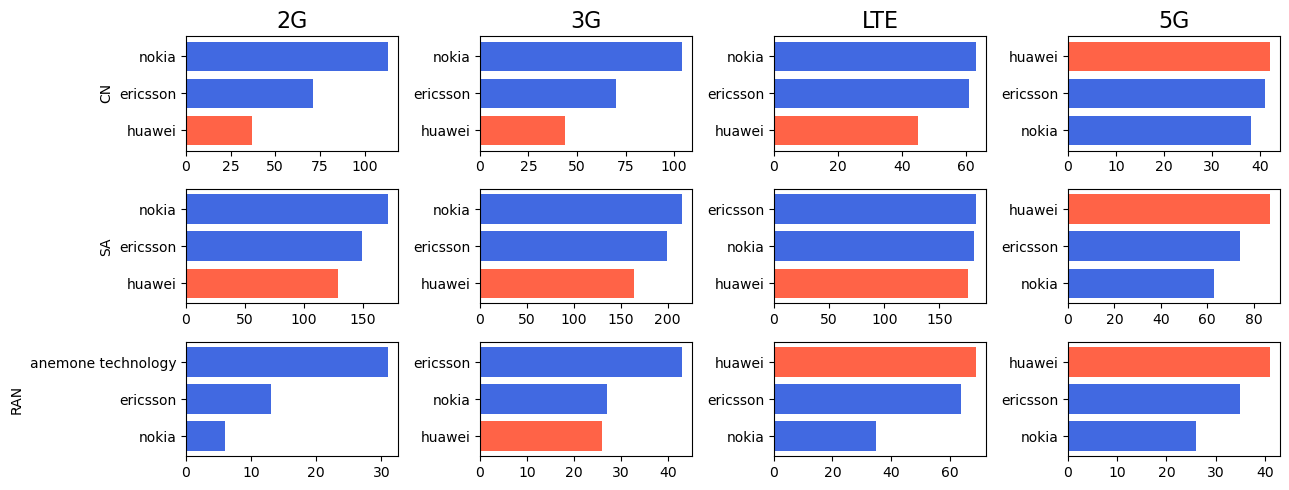

In [10]:
import matplotlib.pyplot as plt

SIZE = 3


########## 企業投入程度繪製 ##########

FOCUS = 'huawei'
CLASSIFIER = 'Primary rapporteur company'


########## 國家投入程度繪製 ##########

# FOCUS = 'China'
# CLASSIFIER = 'Country'


def color_if_FOCUS():
    return ["tomato" if i == FOCUS else "royalblue" for i in primary_company.index]

def set_CLASSIFIER(tec_series, group):
    return tec_series.loc[tec_series['Technical Specification Groups'] == f'{group}'][CLASSIFIER].value_counts()[:SIZE]

plt.subplots(figsize=(13, 5))

##### C #####
plt.subplot(3, 4, 1) # 共 row 2 x column 2, count = 1
primary_company = set_CLASSIFIER(output_2G,'C')
plt.barh(primary_company.index, primary_company, color=color_if_FOCUS())
plt.gca().invert_yaxis()
plt.ylabel('CN')
plt.title('2G', fontsize=16)

plt.subplot(3, 4, 2) # 共 row 2 x column 2, count = 1
primary_company = set_CLASSIFIER(output_3G,'C')
plt.barh(primary_company.index, primary_company, color=color_if_FOCUS())
plt.gca().invert_yaxis()
plt.title('3G', fontsize=16)

plt.subplot(3, 4, 3) # 共 row 2 x column 2, count = 1
primary_company = set_CLASSIFIER(output_LTE,'C')
plt.barh(primary_company.index, primary_company, color=color_if_FOCUS())
plt.gca().invert_yaxis()
plt.title('LTE', fontsize=16)

plt.subplot(3, 4, 4) # 共 row 2 x column 2, count = 1
primary_company = set_CLASSIFIER(output_5G,'C')
plt.barh(primary_company.index, primary_company, color=color_if_FOCUS())
plt.gca().invert_yaxis()
plt.title('5G', fontsize=16)


##### S #####
plt.subplot(3, 4, 5) # 共 row 2 x column 2, count = 1
primary_company = set_CLASSIFIER(output_2G,'S')
plt.barh(primary_company.index, primary_company, color=color_if_FOCUS())
plt.gca().invert_yaxis()
plt.ylabel('SA')

plt.subplot(3, 4, 6) # 共 row 2 x column 2, count = 1
primary_company = set_CLASSIFIER(output_3G,'S')
plt.barh(primary_company.index, primary_company, color=color_if_FOCUS())
plt.gca().invert_yaxis()

plt.subplot(3, 4, 7) # 共 row 2 x column 2, count = 1
primary_company = set_CLASSIFIER(output_LTE,'S')
plt.barh(primary_company.index, primary_company, color=color_if_FOCUS())
plt.gca().invert_yaxis()


plt.subplot(3, 4, 8) # 共 row 2 x column 2, count = 1
primary_company = set_CLASSIFIER(output_5G,'S')
plt.barh(primary_company.index, primary_company, color=color_if_FOCUS())
plt.gca().invert_yaxis()



##### R #####
plt.subplot(3, 4, 9) # 共 row 2 x column 2, count = 1
primary_company = set_CLASSIFIER(output_2G,'R')
plt.barh(primary_company.index, primary_company, color=color_if_FOCUS())
plt.gca().invert_yaxis()
plt.ylabel('RAN')

plt.subplot(3, 4, 10) # 共 row 2 x column 2, count = 1
primary_company = set_CLASSIFIER(output_3G,'R')
plt.barh(primary_company.index, primary_company, color=color_if_FOCUS())
plt.gca().invert_yaxis()


plt.subplot(3, 4, 11) # 共 row 2 x column 2, count = 1
primary_company = set_CLASSIFIER(output_LTE,'R')
plt.barh(primary_company.index, primary_company, color=color_if_FOCUS())
plt.gca().invert_yaxis()


plt.subplot(3, 4, 12) # 共 row 2 x column 2, count = 1
primary_company = set_CLASSIFIER(output_5G,'R')
plt.barh(primary_company.index, primary_company, color=color_if_FOCUS())
plt.gca().invert_yaxis()



plt.tight_layout()
plt.savefig(f'result/top {SIZE} of {CLASSIFIER} and focus on {FOCUS} - all.png')

## 3-4 企業/國家投入在跨技術程度

In [24]:
output.head(1)
output['Across Tech'].value_counts()

None      2356
type 2    1689
type 4     976
type 3     532
type 1     510
type 6     420
type 5     330
Name: Across Tech, dtype: int64

In [57]:
output_type_0 = output.loc[output['Across Tech'] == 'None'].replace('waiting for new company', 'waiting').replace('dolby laboratories inc.', 'dolby')
output_type_1 = output.loc[output['Across Tech'] == 'type 1'].replace('waiting for new company', 'waiting').replace('dolby laboratories inc.', 'dolby')
output_type_2 = output.loc[output['Across Tech'] == 'type 2'].replace('waiting for new company', 'waiting').replace('dolby laboratories inc.', 'dolby')
output_type_3 = output.loc[output['Across Tech'] == 'type 3'].replace('waiting for new company', 'waiting').replace('dolby laboratories inc.', 'dolby')
output_type_4 = output.loc[output['Across Tech'] == 'type 4'].replace('waiting for new company', 'waiting').replace('dolby laboratories inc.', 'dolby')
output_type_5 = output.loc[output['Across Tech'] == 'type 5'].replace('waiting for new company', 'waiting').replace('dolby laboratories inc.', 'dolby')
output_type_6 = output.loc[output['Across Tech'] == 'type 6'].replace('waiting for new company', 'waiting').replace('dolby laboratories inc.', 'dolby')

print(len(output_type_0))
print(len(output_type_1))
print(len(output_type_2))
print(len(output_type_3))
print(len(output_type_4))
print(len(output_type_5))
print(len(output_type_6))
output_3G.head(1)

2356
510
1689
532
976
330
420


,Spec No,Type,Title,Status,Primary Resp Grp,Technical Specification Groups,Primary rapporteur name,Primary rapporteur company,Country,Initial planned Release,Publication,Common IMS,Technology,Across Tech
1,22.153,Technical Specification (TS),Multimedia priority service,Under change control,S1,S,James Garrahan,applied communication sciences,Indonesia,Rel-8,For publication,True,3G,type 3


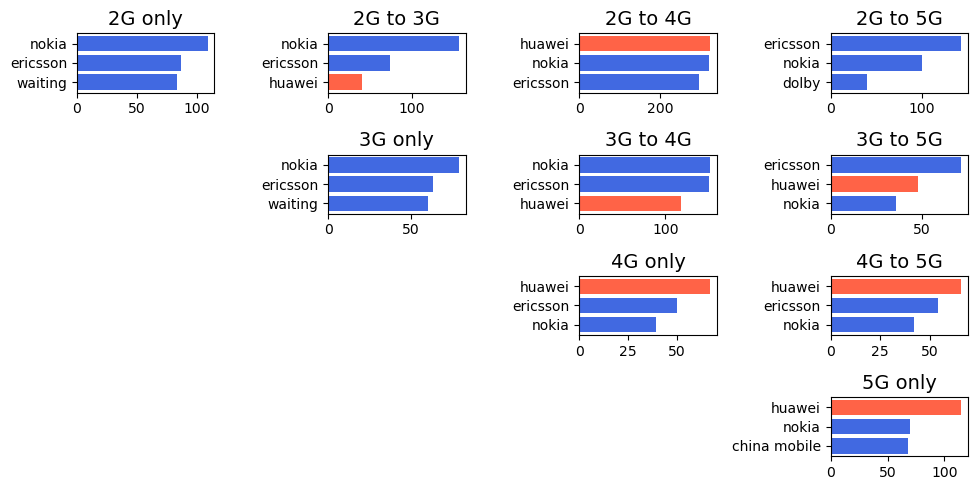

In [58]:
import matplotlib.pyplot as plt

SIZE = 3


########## 企業投入程度繪製 ##########

FOCUS = 'huawei'
CLASSIFIER = 'Primary rapporteur company'


########## 國家投入程度繪製 ##########

# FOCUS = 'China'
# CLASSIFIER = 'Country'


def color_if_FOCUS():
    return ["tomato" if i == FOCUS else "royalblue" for i in primary_company.index]

def set_CLASSIFIER(tec_series, group):
    return tec_series.loc[tec_series['Technical Specification Groups'] == f'{group}'][CLASSIFIER].value_counts()[:SIZE]


plt.subplots(figsize=(10, 5))


##### start with 2G #####
plt.subplot(4, 4, 1) 
primary_company = output_type_0.loc[output_type_0['Technology'] == '2G'][CLASSIFIER].value_counts()[:SIZE]
plt.barh(primary_company.index, primary_company, color=color_if_FOCUS())
plt.gca().invert_yaxis()
plt.title('2G only', fontsize=14)

plt.subplot(4, 4, 2) 
primary_company = output_type_1[CLASSIFIER].value_counts()[:SIZE]
plt.barh(primary_company.index, primary_company, color=color_if_FOCUS())
plt.gca().invert_yaxis()
plt.title('2G to 3G', fontsize=14)

plt.subplot(4, 4, 3) 
primary_company = output_type_2[CLASSIFIER].value_counts()[:SIZE]
plt.barh(primary_company.index, primary_company, color=color_if_FOCUS())
plt.gca().invert_yaxis()
plt.title('2G to 4G', fontsize=14)

plt.subplot(4, 4, 4) 
primary_company = output_type_3[CLASSIFIER].value_counts()[:SIZE]
plt.barh(primary_company.index, primary_company, color=color_if_FOCUS())
plt.gca().invert_yaxis()
plt.title('2G to 5G', fontsize=14)


##### start with 3G #####
plt.subplot(4, 4, 6) 
primary_company = output_type_0.loc[output_type_0['Technology'] == '3G'][CLASSIFIER].value_counts()[:SIZE]
plt.barh(primary_company.index, primary_company, color=color_if_FOCUS())
plt.gca().invert_yaxis()
plt.title('3G only', fontsize=14)

plt.subplot(4, 4, 7) 
primary_company = output_type_4[CLASSIFIER].value_counts()[:SIZE]
plt.barh(primary_company.index, primary_company, color=color_if_FOCUS())
plt.gca().invert_yaxis()
plt.title('3G to 4G', fontsize=14)

plt.subplot(4, 4, 8) 
primary_company = output_type_5[CLASSIFIER].value_counts()[:SIZE]
plt.barh(primary_company.index, primary_company, color=color_if_FOCUS())
plt.gca().invert_yaxis()
plt.title('3G to 5G', fontsize=14)


##### start with 4G #####
plt.subplot(4, 4, 11) 
primary_company = output_type_0.loc[output_type_0['Technology'] == 'LTE'][CLASSIFIER].value_counts()[:SIZE]
plt.barh(primary_company.index, primary_company, color=color_if_FOCUS())
plt.gca().invert_yaxis()
plt.title('4G only', fontsize=14)

plt.subplot(4, 4, 12) 
primary_company = output_type_6[CLASSIFIER].value_counts()[:SIZE]
plt.barh(primary_company.index, primary_company, color=color_if_FOCUS())
plt.gca().invert_yaxis()
plt.title('4G to 5G', fontsize=14)


##### start with 5G #####
plt.subplot(4, 4, 16) 
primary_company = output_type_0.loc[output_type_0['Technology'] == '5G'][CLASSIFIER].value_counts()[:SIZE]
plt.barh(primary_company.index, primary_company, color=color_if_FOCUS())
plt.gca().invert_yaxis()
plt.title('5G only', fontsize=14)


plt.tight_layout()
plt.savefig(f'result/top {SIZE} of {CLASSIFIER} and focus on {FOCUS} - across tech.png')

In [9]:
# 單一技術之企業投入程度
output.loc[output['Across Tech'] == 'None']['Primary rapporteur company'].value_counts()[:8]

# 4. 其他分析

## 4-1 各技術時代中，未提交至WP之spec數量

In [138]:
count = 0
con_2 = 0
con_3 = 0
con_4 = 0
con_5 = 0

for i in SpecificationList_df['Spec No']:
    if i not in list(output['Spec No']):
        indx = list(SpecificationList_df['Spec No']).index(i)
#         print(i)
#         print(list(SpecificationList_df['Technology'])[indx])
#         print('=======================')
#         print(i)
#         count += 1
        if '2G' in str(list(SpecificationList_df['Technology'])[indx]):
            con_2 += 1
        if '3G' in str(list(SpecificationList_df['Technology'])[indx]):
            con_3 += 1
        if 'LTE' in str(list(SpecificationList_df['Technology'])[indx]):
            con_4 += 1
        if '5G' in str(list(SpecificationList_df['Technology'])[indx]):
            con_5 += 1
        
count

0

In [12]:
print('2G:' , con_2)
print('3G:' , con_3)
print('4G:' , con_4)
print('5G:' , con_5)

2G: 800
3G: 683
4G: 447
5G: 321


## 4-2 企業投入最多之spec與次數

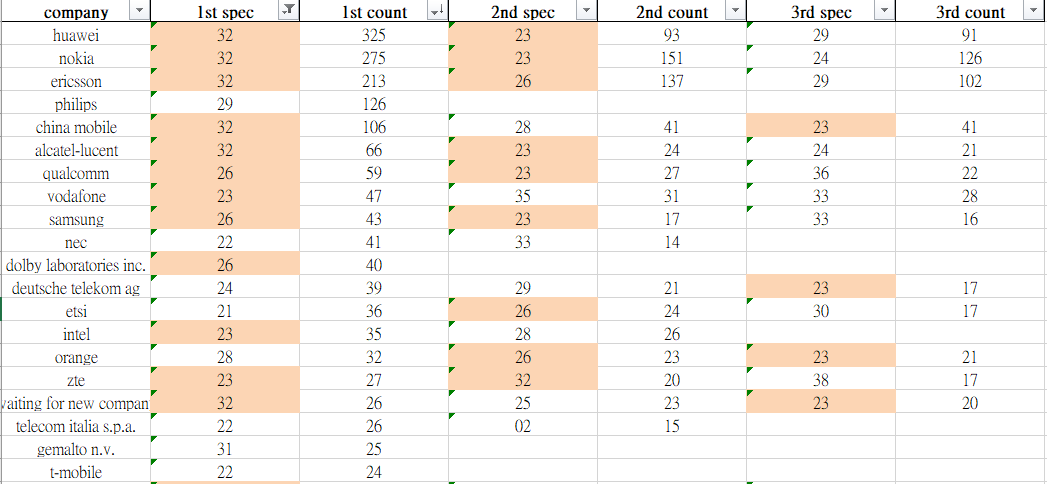

In [15]:
spec_by_cmp = {}

for index, row in output.iterrows():
    cmp = row['Primary rapporteur company']
    spec = row['Spec No'].split('.')[0]
    
    if cmp not in spec_by_cmp.keys():
        spec_by_cmp[cmp] = {}
        
    if spec not in spec_by_cmp[cmp].keys():
        spec_by_cmp[cmp][spec] = 1
    else:
        spec_by_cmp[cmp][spec] += 1

In [62]:
spec_by_cmp_db = pd.DataFrame()

for key, value in spec_by_cmp.items():
    spec_by_cmp_dict = {'company':key,'1st spec':'','1st count':'','2nd spec':'','2nd count':'','3rd spec':'','3rd count':''}
    for key_in_v, value_in_v in value.items():

        if value_in_v == sorted(value.values(), reverse = True)[0] and value_in_v > 10:
            spec_by_cmp_dict['1st spec'] = key_in_v
            spec_by_cmp_dict['1st count'] = value_in_v

        try:
            if value_in_v == sorted(value.values(), reverse = True)[1] and value_in_v > 10:
                spec_by_cmp_dict['2nd spec'] = key_in_v
                spec_by_cmp_dict['2nd count'] = value_in_v
        except:
            pass
        
        try:
            if value_in_v == sorted(value.values(), reverse = True)[2] and value_in_v > 10:
                spec_by_cmp_dict['3rd spec'] = key_in_v
                spec_by_cmp_dict['3rd count'] = value_in_v
        except:
            pass
        
    db = pd.DataFrame(spec_by_cmp_dict, index=[0])
#     print(db)
    spec_by_cmp_db = pd.concat([spec_by_cmp_db, db], axis=0, ignore_index=True)
spec_by_cmp_db.to_excel('company_contribute_on_spec.xlsx', encoding='utf_8_sig', index=False)

C:\Users\Penny\anaconda3\lib\site-packages\pandas\util\_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)


## 4-3 各spec所更新之總版本數量

In [88]:
spec_count = {}

for index, row in output.iterrows():
    spec = row['Spec No'].split('.')[0]
    
    if spec not in spec_count.keys():
        spec_count[spec] = 1
    else:
        spec_count[spec] += 1

pd.DataFrame.from_dict(spec_count, orient='index').to_excel('spec_count.xlsx', encoding='utf_8_sig', index=True)

C:\Users\Penny\anaconda3\lib\site-packages\pandas\util\_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)


In [87]:
pd.DataFrame.from_dict(spec_count, orient='index')

,0
22,97
33,133
23,229
29,216
36,10
27,4
24,163
38,92
31,26
28,119
